# Statistics & US Politics... again?
## Mini-project using Bayesian Statistics and SciPy

I hear you... more US politics? Not again!

Thankfully, we're not looking at recent data; we're using polls and election results from the 1988 Presidential election instead from our two CSVs, `polls.csv` and `election88.csv`. This mini-project involves the following steps:

1. First, we choose poll and election results from three different states. 
2. For each state, we calculate the posterior probability distribution, for the probability of people voting for Bush based on the polls using a prior Beta distribution and the election results for a binomial likelihood function. 
3. We plot the cumulative distribution function of the posterior probability.

### Importing libraries.

In [1]:
from __future__ import division
import numpy as np
import pandas as pd
import math
from scipy.special import gamma as Gamma
from scipy.stats import beta
import matplotlib.pyplot as plt
%matplotlib inline

### Data wrangling.

Poll data before the election:

In [2]:
pre_poll = pd.read_csv('assets/mini/polls.csv')

del pre_poll['Unnamed: 0']
del pre_poll['org']
pre_poll.head()

,year,survey,bush,state,edu,age,female,black,weight
0,1,9152,1.0,7,2,2,1,0,1403
1,1,9152,1.0,33,4,3,0,0,778
2,1,9152,0.0,20,2,1,1,0,1564
3,1,9152,1.0,31,3,2,1,0,1055
4,1,9152,1.0,18,3,1,1,0,1213


Election results:

In [15]:
election88 = pd.read_csv('assets/mini/election88.csv')
del election88["Unnamed: 0"]
election88.head()

,stnum,st,electionresult,samplesize,raking,_merge
0,1,AL,0.59,203,0.673067,3
1,2,AK,0.60,0,NaN,1
2,3,AZ,0.60,194,0.568980,3
3,4,AR,0.56,121,0.563672,3
4,5,CA,0.51,1493,0.531725,3


### Data dictionary.

We'll create a dictionary with the general poll percentages for each state. Our for loop subsets the data and removes the NaNs first, then calculates the 'Bush quotient' as a measure of how popular he is in each state. 

In [3]:
container2 ={}
for state in pre_poll['state'].unique(): 
    c1 = pre_poll['state'] == state
    subset_interest = pre_poll[c1]  # Subsetting the data 
    contain = subset_interest['bush'].unique()  
    contain = contain[~np.isnan(contain)]   # Remove the NaNs - Think why can't we use dropna()?
        
    if len(contain) == 2:
        bush_quotient = float(subset_interest['bush'].value_counts()[1])/(float(subset_interest['bush'].value_counts()[1])+float(subset_interest['bush'].value_counts()[0]))
        temp_name = str(state)
        container2[temp_name] = bush_quotient

We then use this dictionary to create a pandas DataFrame for easier handling.

In [25]:
df_polls = pd.DataFrame(
    {'stnum': container2.keys(),'poll': container2.values()})
df_polls['stnum'] = df_polls['stnum'].apply(int)
df_polls.shape

(48, 2)

Ranking states by Bush's popularity:

In [26]:
df_polls.sort_values(by='poll', ascending=False).head()

,poll,stnum
16,0.782609,45
21,0.710692,1
6,0.698413,25
36,0.692913,17
18,0.675862,43


### Merging the two datasets.

We do a left join using the merge method on both Dataframes, and get the following:

In [27]:
election88 = election88[['stnum','st','electionresult','samplesize']]
election88 = election88.merge(df_polls,left_on='stnum',right_on='stnum',how='left')
election88.dropna(inplace=True)

election88 = election88[['stnum','st','electionresult','samplesize']]
election88 = election88.merge(df_polls,left_on='stnum',right_on='stnum',how='left')
election88.dropna(inplace=True)

election88['result_persons'] = np.round(
    election88.electionresult * election88.samplesize)
election88['poll_persons'] = np.round(
    election88.poll * election88.samplesize)
election88['result_persons'] = election88.result_persons.astype(int)
election88['poll_persons'] = election88.poll_persons.astype(int)

election88

,stnum,st,electionresult,samplesize,poll,result_persons,poll_persons
0,1,AL,0.59,203,0.710692,120,144
1,3,AZ,0.60,194,0.589286,116,114
2,4,AR,0.56,121,0.584158,68,71
3,5,CA,0.51,1493,0.570312,761,851
4,6,CO,0.53,181,0.593103,96,107
5,7,CT,0.52,171,0.529851,89,91
6,8,DE,0.56,39,0.378378,22,15
7,10,FL,0.61,750,0.638066,458,479
8,11,GA,0.60,316,0.587121,190,186
9,13,ID,0.62,42,0.500000,26,21


In [28]:
list_post = []
for s in election88["stnum"]:
    data = (election88[election88["stnum"] == s])
    state = data.values[0,1]
    n = data.values[0,3]
    k = data.values[0,5]
    alpha_p = data.values[0,6]
    beta_p = n-alpha_p
    a = k + alpha_p
    b = n - k + beta_p
    list_post.append((state,a,b,alpha_p,beta_p))

In [29]:
def func_plot_1(values,my_list):
    i = 0
    for post in my_list:
        list_prob = []
        list_prob_1 = []
        for n in range(100):
            list_prob.append(beta.cdf(0.01*(n+1),post[1],post[2])
                     -beta.cdf(0.01*n,post[1],post[2]))
            list_prob_1.append(beta.cdf(0.01*(n+1),post[3],post[4])
                     -beta.cdf(0.01*n,post[3],post[4]))

        plt.plot(values,list_prob,'-',color=colors[i%8],linewidth=3,label=post[0])
        plt.plot(values,list_prob_1,'--',color=colors[i%8],linewidth=3)
        plt.legend(loc='upper left',fontsize=20)
        plt.xlabel('Percentage pro Bush',fontsize=20)
        plt.ylabel('Posterior Probability',fontsize=20)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        i += 1

### Posterior Probabilities.

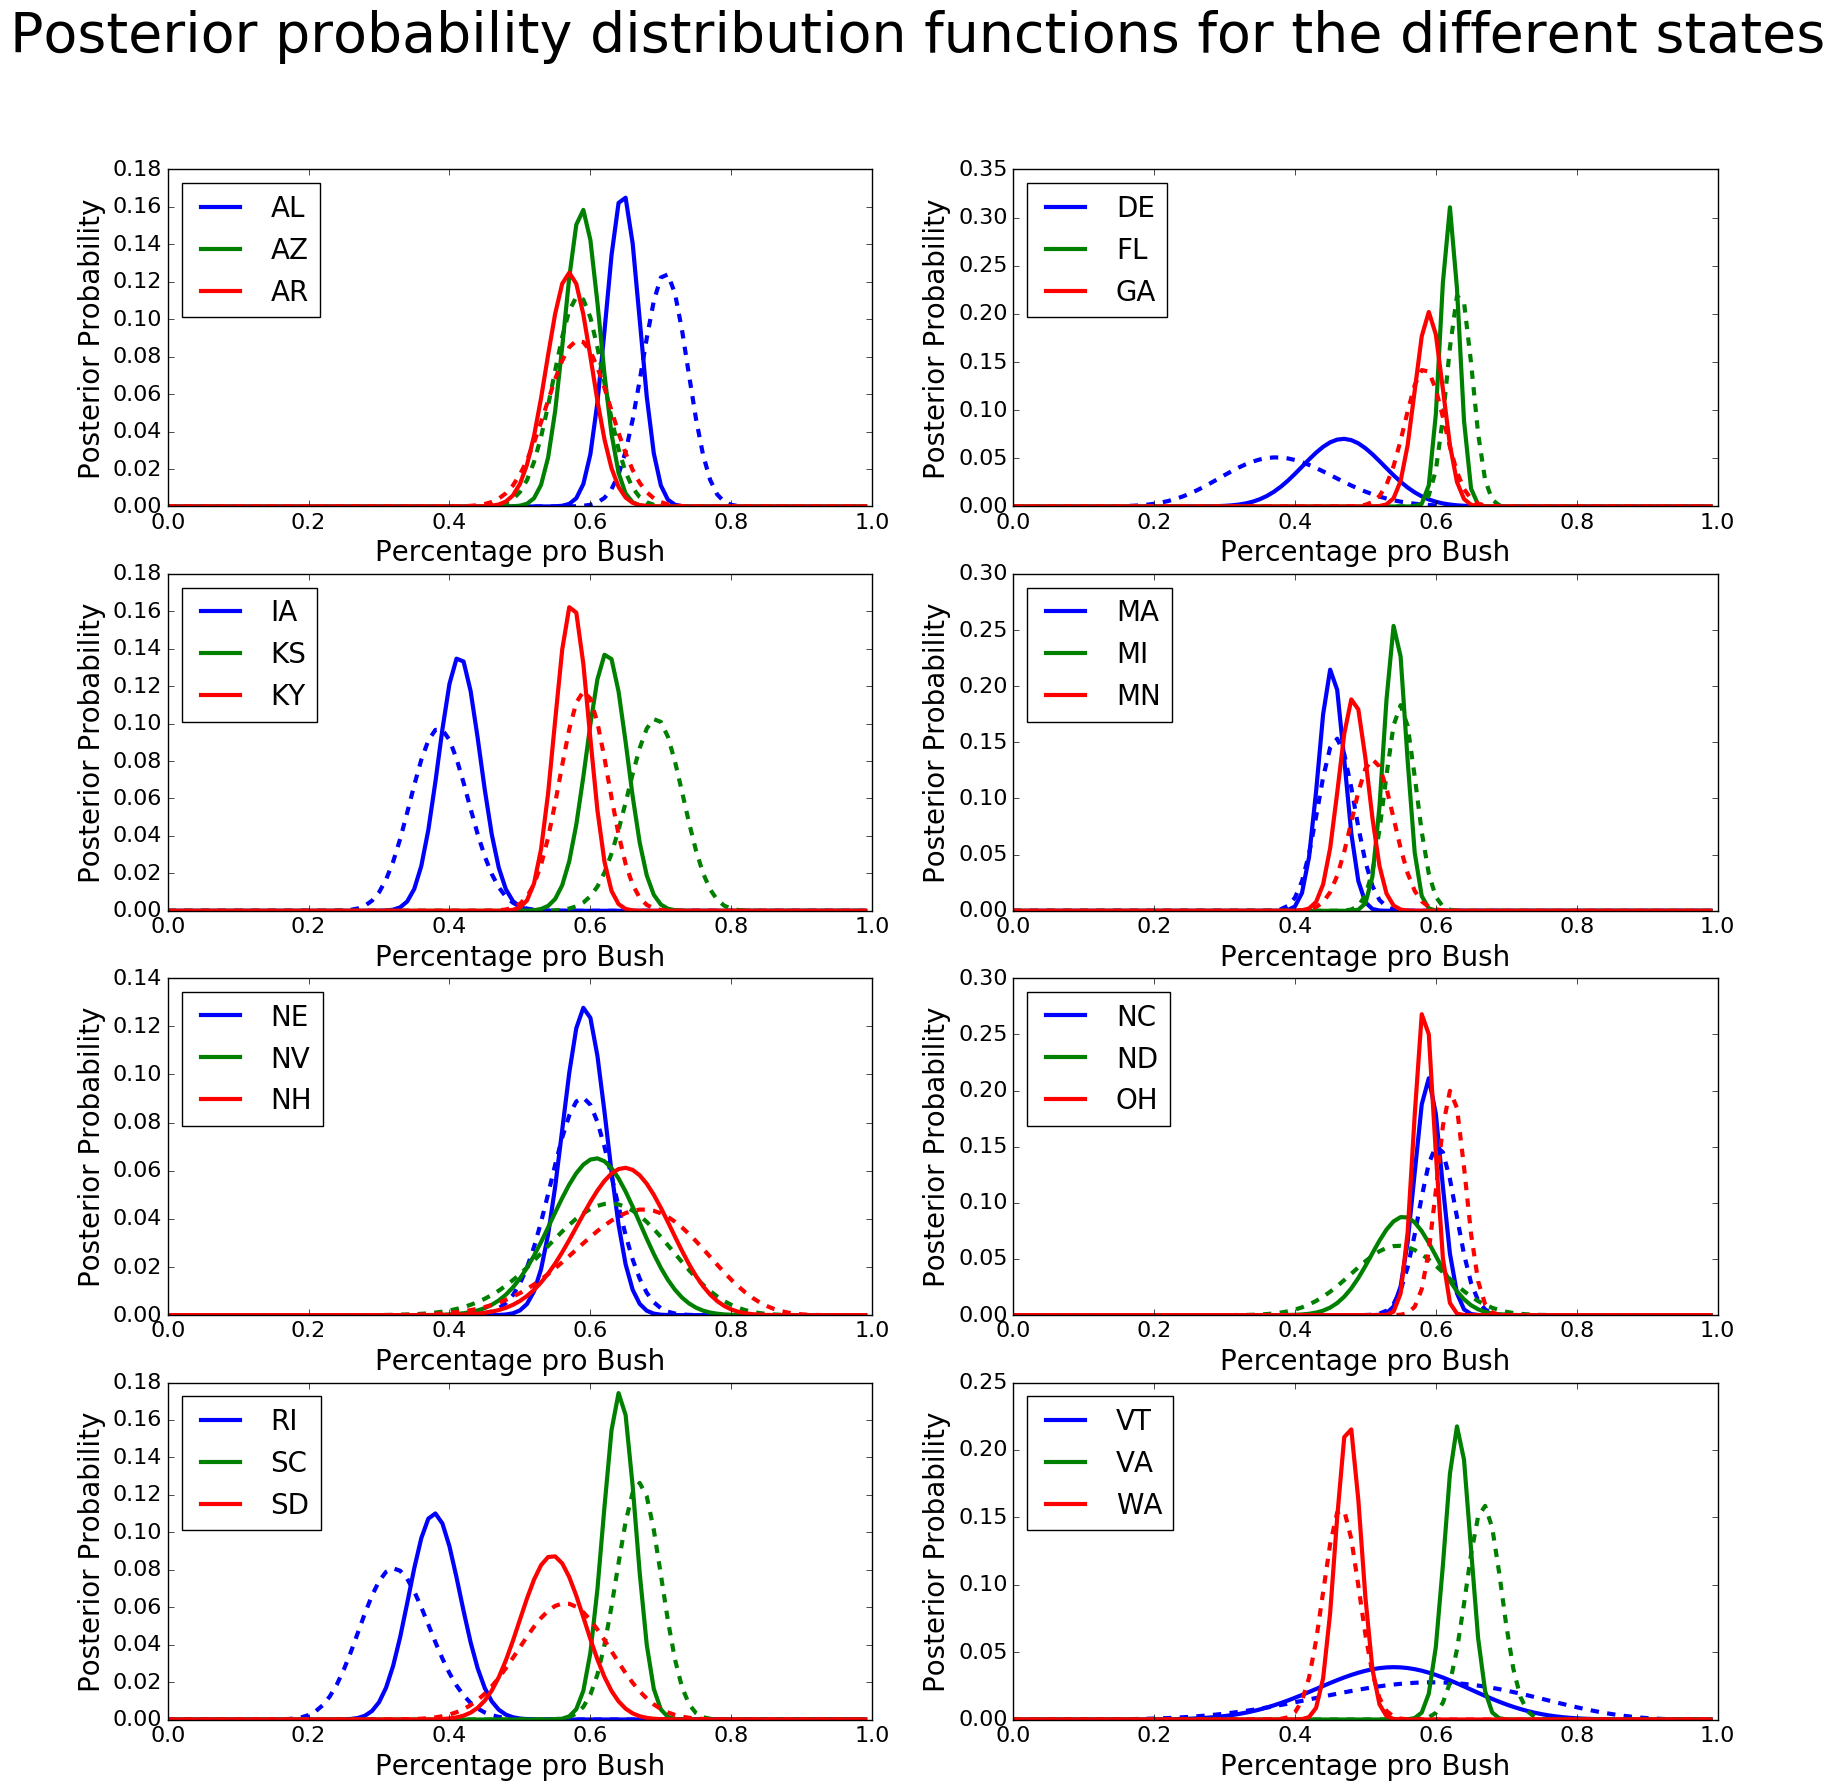

In [36]:
colors = ('b', 'g', 'r')

plt.figure(figsize=(20,20))
plt.suptitle('Posterior probability distribution functions for the different states', 
             fontsize=40)
values = np.arange(0,1,0.01)
j = np.array([0,3])
for i in range(8):
    j1 = j + i*6
    plt.subplot(4, 2, i+1)
    func_plot_1(values,list_post[j1[0]:j1[1]])
    
plt.show()

### Cumulative Distribution Functions.

In [37]:
def func_plot(values,my_list):
    i = 0
    for post in my_list:
        plt.plot(values,beta.cdf(values,post[1],post[2]),'-',color=colors[i%8],linewidth=3,label=post[0])
        plt.plot(values,beta.cdf(values,post[3],post[4]),'--',color=colors[i%8],linewidth=3)
        plt.legend(loc='upper left',fontsize=20)
        plt.xlabel('x',fontsize=20)
        plt.ylabel('P(theta <x)',fontsize=20)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        i += 1

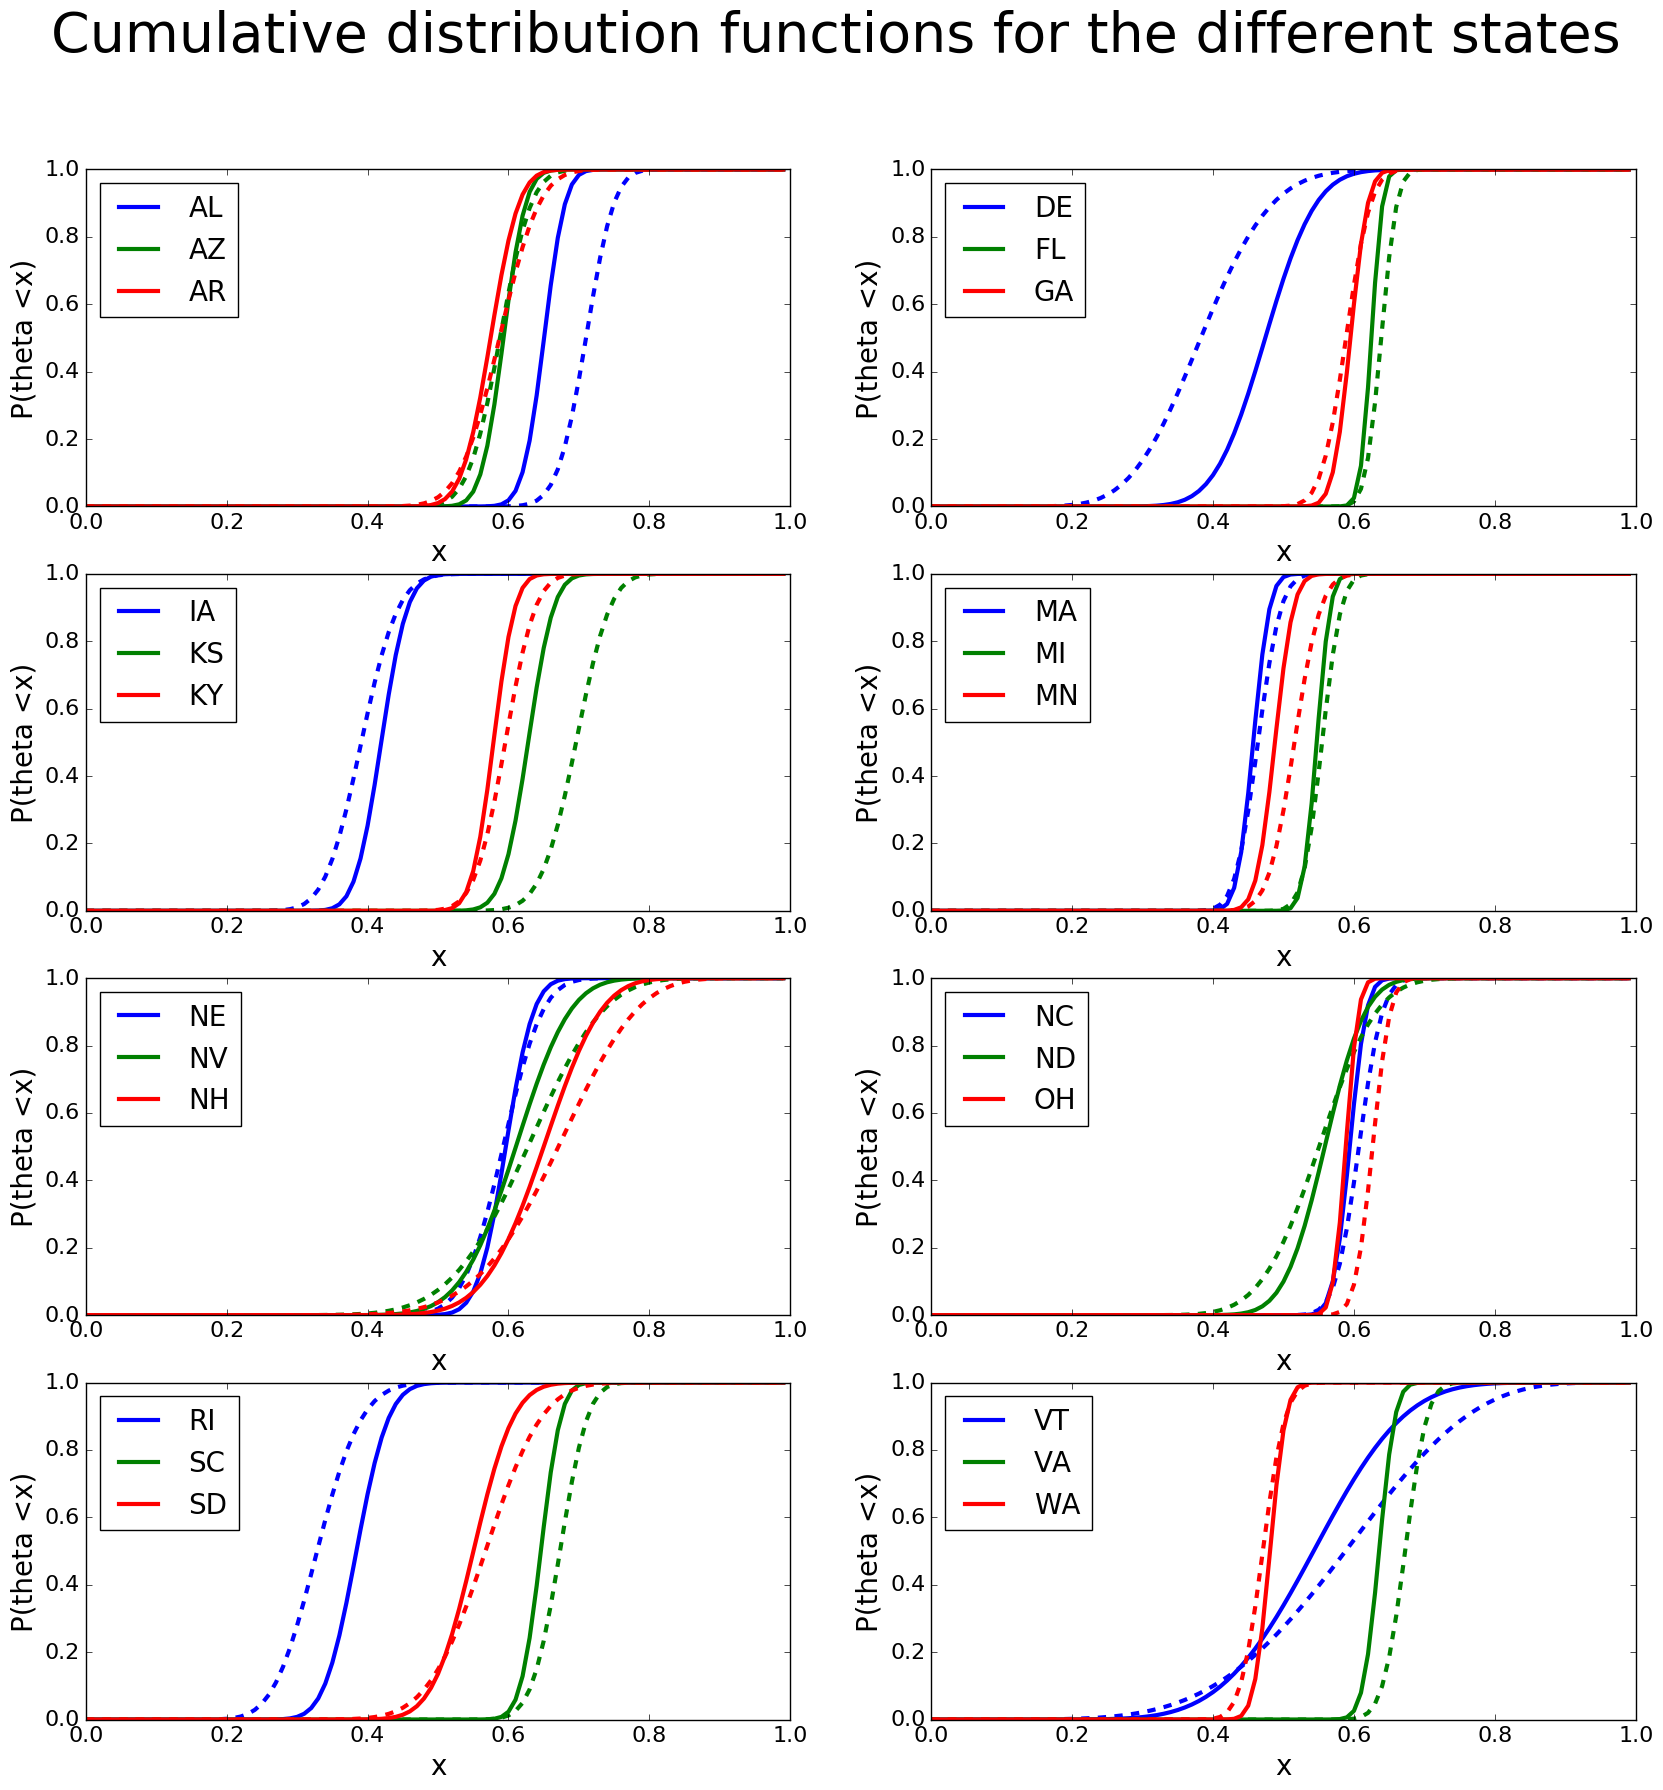

In [38]:
plt.figure(figsize=(20,20))
plt.suptitle('Cumulative distribution functions for the different states', 
             fontsize=40)
values = np.arange(0,1,0.01)
j = np.array([0,3])
for i in range(8):
    j1 = j + i*6
    plt.subplot(4, 2, i+1)
    func_plot(values,list_post[j1[0]:j1[1]])
    
plt.show()